In [1]:
import sys
if '/usr/users/vogg/.conda/envs/mktrack/lib/python3.8/site-packages' not in sys.path:
    sys.path.insert(0, '/usr/users/vogg/.conda/envs/mktrack/lib/python3.8/site-packages')
    sys.path.insert(0, '/usr/users/vogg/monkey-tracking-in-the-wild/src')
    sys.path.insert(0, '/usr/users/vogg/monkey-tracking-in-the-wild/src/lib')

import os
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from torchvision.transforms import transforms as T

import _init_paths
from models.model import create_model, load_model
from models.decode import mot_decode, _topk, map2orig
from tracking_utils.utils import *
from utils.post_process import ctdet_post_process
from utils.image import get_affine_transform
from models.utils import _tranpose_and_gather_feat
import datasets.dataset as dataset

/usr/users/vogg/monkey-tracking-in-the-wild/src/lib


In [2]:
model = create_model('hrnet_32', heads =  {'hm': 2, 'wh': 2, 'id': 128, 'reg': 2, 'gc': 3}, 
                    head_conv = 256, num_gc_cls = 8, clsID4GC = 0, gc_with_roi = True)

model = load_model(model, f'../exp/mot/lemur_ids_cleaned1_squareroi/model_60.pth')
model = model.to(torch.device('cuda'))
model.eval();

class_names = ['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red', 'Uns']

{'hm': 2, 'wh': 2, 'id': 128, 'reg': 2, 'gc': 3}
loaded ../exp/mot/lemur_ids_cleaned1_squareroi/model_60.pth, epoch 60


### Image Label Dataset

In [3]:

dset = dataset.ImageLabelDataset(
    root="/usr/users/vogg/Labelling/Lemurs/Individual_imgs/",
    file_list='/usr/users/vogg/monkey-tracking-in-the-wild/src/data/lemur_ids_cleaned1.train',
    resize=True
    )

i = 120
image, img_path, original_shape, labels = dset.__getitem__(i)
img0 = np.moveaxis(image, 0, -1)
im_blob = torch.from_numpy(image).cuda().unsqueeze(0)
gt_bbox = labels[:,2:6][labels[:,0]==0] / 4
labels = labels[:,-1][labels[:,0]==0]





### Joint Dataset

In [20]:
class opts:
    pass

opt = opts()
opt.use_gc = True
opt.gc_cls_names = "Cha,Flo,Gen,Geo,Her,Rab,Red,Uns"
opt.reid_cls_names = "lemur,box"
opt.cat_spec_wh = True
opt.K = 50
opt.down_ratio = 4
opt.ltrb = False
opt.mse_loss = True
opt.gc_with_roi = True
opt.hm_gauss = True
opt.no_aug_hsv = False
opt.gc_with_roi = True

dset = dataset.JointDataset2(
    opt,
    root="/usr/users/vogg/Labelling/Lemurs/Individual_imgs/",
    paths={
		"lemur_train": '/usr/users/vogg/monkey-tracking-in-the-wild/src/data/lemur_ids_cleaned1.train'
	},
    augment=False, transforms = T.Compose([T.ToTensor()])
    )

i = 0

output = dset.__getitem__(i)

bbox = output['bbox']
input_image = output['input'].numpy()
box_lemur = output['box_lemur_class'].numpy()
labels = output['gc'].numpy()

img0 = np.moveaxis(input_image, 0, -1)
gt_bbox = bbox[:len(box_lemur)][box_lemur == 0] #ignore foodboxes
im_blob = torch.from_numpy(input_image).cuda().unsqueeze(0)

dataset summary
OrderedDict([('lemur_train', defaultdict(<class 'int'>, {0: 650.0, 1: 696.0}))])
start index
OrderedDict()


### Validation Videos Dataset

In [28]:
path_val = '/usr/users/agecker/datasets/lemur_ids/alpha_ID_validation_snippets/e1_c4_11_19140_20880.mp4'
frame_number = 10  # Specify the frame number you want to extract

cap = cv2.VideoCapture(path_val)

# Set the frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
cap.release()


img0,_,_,_ = dataset.letterbox(frame, height=608, width =1088)
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img0 = img0 / 255.0
im_blob = torch.from_numpy(img0).cuda().unsqueeze(0).permute(0,3,1,2).float()

### Apply model to one sample

In [6]:
def get_embeddings(im_blob, gt_bbox):

    width = im_blob.shape[3]
    height = im_blob.shape[2]
    h_out = height // 4
    w_out = width // 4


    with torch.no_grad():
        output = model(im_blob)[-1]
        hm = output['hm'].sigmoid_()
        wh = output['wh']
        reg = output['reg']

        dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                                wh=wh,
                                                reg=reg,
                                                num_classes=hm.size(1),
                                                cat_spec_wh=False,
                                                K=50)

        # Translate and scale bounding box detections.
        dets = map2orig(dets, h_out, w_out, height, width, hm.size(1))
        # Only keep lemur predictions.
        dets = dets[0]

        dets_bbox = torch.from_numpy(dets)
        remain_inds = dets_bbox[:, 4] > 0.1
        dets_bbox = dets_bbox[remain_inds]
        
        if not gt_bbox is None:
            bboxes = torch.Tensor(gt_bbox).cuda()
            cls_logits, embeddings = model.gc_lin(im_blob, bboxes=[bboxes])
            
        else:
            bboxes = dets_bbox[:, :4].cuda() / 4
            cls_logits, embeddings = model.gc_lin(im_blob, bboxes=[bboxes])

    return embeddings.cpu(), bboxes.cpu()


In [119]:

embeddings, bboxes = get_embeddings(im_blob, gt_bbox)


### Apply model to all images

In [7]:
embedding_list = []
label_list = []
frame_list = []


for i in range(dset.__len__()):
    if i%200==0:
        print(i)

    
    if type(dset)==dataset.ImageLabelDataset:
        image, img_path, original_shape, labels = dset.__getitem__(i)
        img0 = np.moveaxis(image, 0, -1)
        im_blob = torch.from_numpy(image).cuda().unsqueeze(0)
        gt_bbox = labels[:,2:6][labels[:,0]==0] / 4
        labels = labels[:,-1][labels[:,0]==0].astype(int)


    
    else:
        output = dset.__getitem__(i)
        bbox = output['bbox']
        input_image = output['input'].numpy()
        box_lemur = output['box_lemur_class'].numpy()
        labels = output['gc'].numpy()
        img0 = np.moveaxis(input_image, 0, -1)
        gt_bbox = bbox[:len(box_lemur)][box_lemur == 0] #ignore foodboxes
        im_blob = torch.from_numpy(input_image).cuda().unsqueeze(0)

    embeddings, _ = get_embeddings(im_blob, gt_bbox)


    embedding_list.append(embeddings)
    label_list.append(labels)
    frame_list.append([i] * len(labels))

0


200
400
600
800
1000
1200
1400
1600


In [16]:
train_embeddings = np.concatenate(embedding_list, axis=0)
train_labels = np.concatenate(label_list)
train_frames = np.concatenate(frame_list)
print(train_embeddings.shape)
print(train_labels.shape)

(3293, 512)
(3293,)


### t-SNE

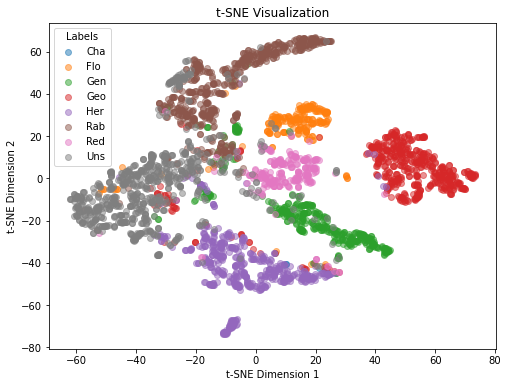

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming your data is stored in 'data' and labels in 'labels'

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(train_embeddings)



# Plot t-SNE embeddings
plt.figure(figsize=(8, 6))
for label in np.unique(train_labels):
    plt.scatter(embedded_data[train_labels == label, 0], embedded_data[train_labels == label, 1], label=class_names[int(label)], alpha = 0.5)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Labels')
plt.show()

In [38]:
class_names[3]

'Geo'

### Visualize example images

In [72]:
## Find George pictures

row_numbers = np.where((embedded_data[:,1] < -40) & (train_labels == 4))
#row_numbers = np.where((train_labels == 3))
row_numbers = row_numbers[0]
row_numbers

array([ 695,  707,  780,  835,  871,  953, 1004, 1055, 1064, 1101, 1178, 1223, 1267, 1392, 1494, 1589, 1746, 1828, 1950, 1990, 2054, 2148, 2174, 2311, 2433, 2452, 2595, 2625, 2669, 2712, 2749, 2788, 2814, 2828, 2980, 2993, 3028, 3042, 3081, 3139, 3145, 3184, 3197, 3249, 3277])

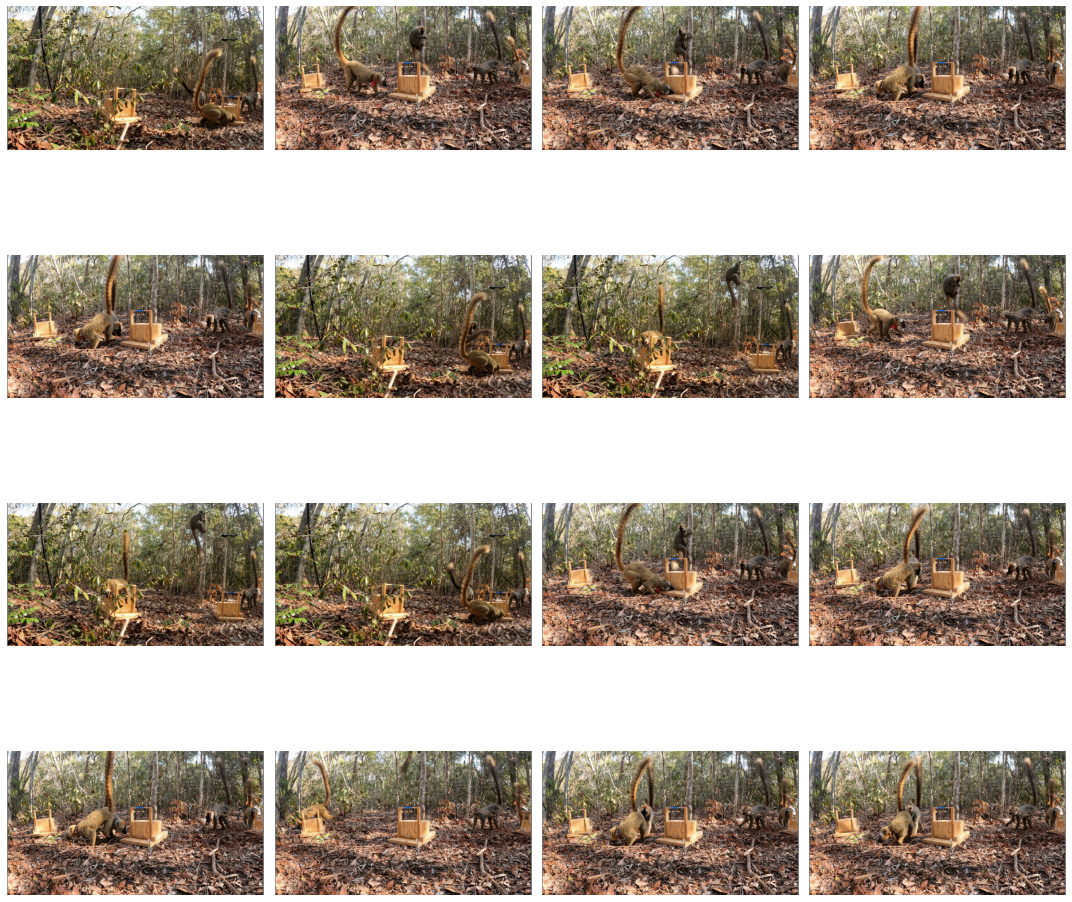

In [73]:
random_indices = np.random.choice(len(row_numbers), size=16, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for i, num in enumerate(train_frames[row_numbers[random_indices]]):
    image, _, _, _ = dset.__getitem__(num)
    img0 = np.moveaxis(image, 0, -1)
    ax = axes[i // 4, i % 4]
    ax.imshow(img0)
    ax.axis('off')
plt.tight_layout()
plt.show()



In [89]:
i = 1589

#print(train_embeddings[i,:])
label = train_labels[i]
frame = train_frames[i]

image, img_path, original_shape, labels = dset.__getitem__(frame)

labels = labels[(labels[:,0]==0) & (labels[:,6]==label),:]

img0 = np.moveaxis(image, 0, -1)
gt_bbox = torch.Tensor(labels[:, 2:6]) #* np.array([width, height, width, height]))


In [8]:
def plot_bbox_w_id(img, bboxes, crop = False, square_size=224):
    image_copy = img.copy()
    
    coords = []

    if bboxes is not None:

        for bbox in bboxes:
            # Extract coordinates from bounding box
            xmin, ymin, xmax, ymax = bbox.astype(int)

            # Draw bounding box on image
            image_copy = cv2.rectangle(image_copy, np.array([xmin, ymin]).astype(int), np.array([xmax, ymax]).astype(int), color=(255, 255, 0), thickness=5)


            coords.append(np.array([xmin, ymin]).astype(int))

    if crop:

        xmin, ymin, xmax, ymax = bboxes[0].astype(int)
        # Crop the image within the bounding box
        cropped_image = img[ymin:ymax, xmin:xmax, :]

        # Resize the cropped image to be square
        cropped_image = cv2.resize(cropped_image, (square_size, square_size))
        return cropped_image, [(5,5)]
    else:
        return image_copy, coords

In [91]:
labels

array([[          0,          72,      818.06,      215.16,      969.84,      348.41,           4]])

Text(0.5, 1.0, 'Ground Truth')

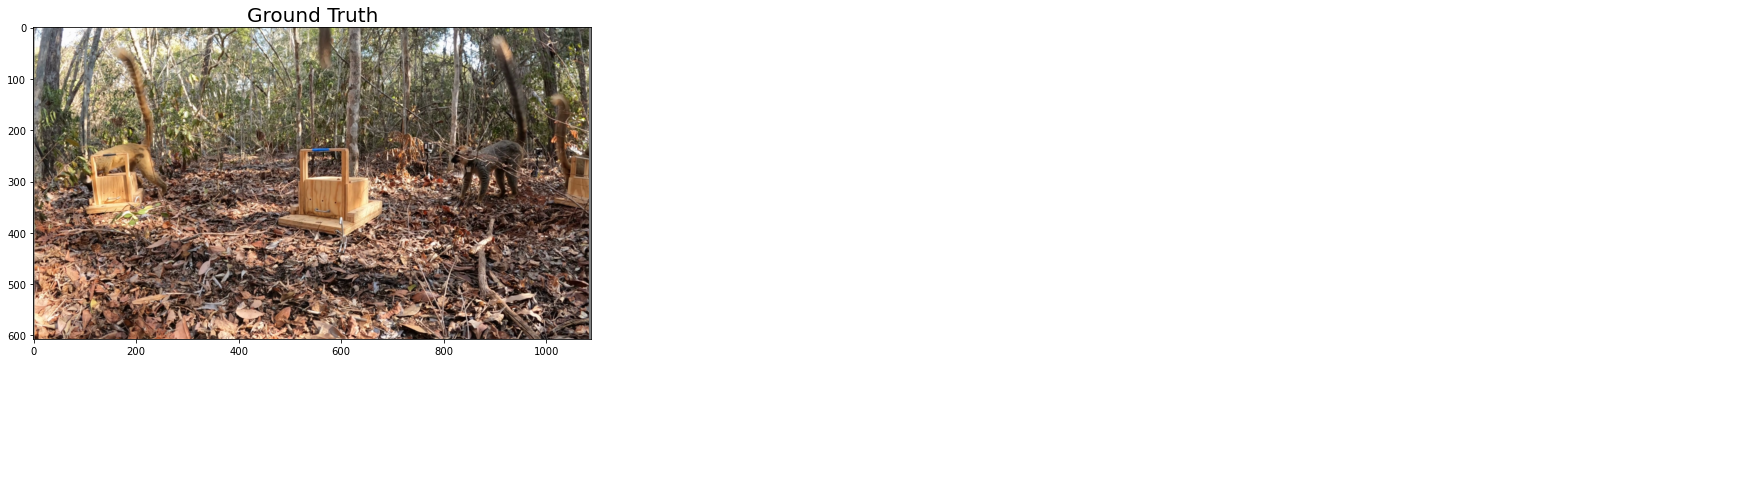

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))


image, coords = plot_bbox_w_id(img0, gt_bbox.numpy() * 4, crop = False)
#image2, coords2 = plot_bbox_w_id(img0, dets_bbox)

ax.imshow(image)


for i, c in enumerate(coords):
    ax.annotate(class_names[int(labels[i])], c, fontsize=14, color = "yellow",
                bbox=dict(boxstyle='round', facecolor='black', edgecolor='none'))
    

ax.set_title('Ground Truth', fontsize=20)

### Find k nearest neighbors



In [9]:
### Choosing a given embedding from the list

frame = train_frames[871]

image, img_path, original_shape, labels = dset.__getitem__(frame)
img0 = np.moveaxis(image, 0, -1)
im_blob = torch.from_numpy(image).cuda().unsqueeze(0)
gt_bbox = labels[:,2:6][labels[:,0]==0] / 4
labels = labels[:,-1][labels[:,0]==0]


NameError: name 'train_frames' is not defined

In [23]:
## Choosing from validation videos

path_val = '/usr/users/agecker/datasets/lemur_ids/alpha_ID_validation_snippets/e1_c4_11_19140_20880.mp4'
frame_number = 10  # Specify the frame number you want to extract

cap = cv2.VideoCapture(path_val)

# Set the frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
cap.release()


img0,_,_,_ = dataset.letterbox(frame, height=608, width =1088)
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img0 = img0 / 255.0
im_blob = torch.from_numpy(img0).cuda().unsqueeze(0).permute(0,3,1,2).float()

tensor([[154.37448,  50.37207, 229.10992, 112.38033],
        [115.82188,  63.58545, 163.07443, 111.23076]])


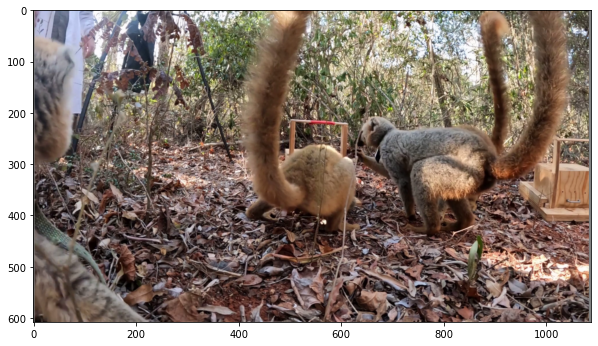

In [24]:

val_emb, bboxes = get_embeddings(im_blob, None)
print(bboxes)
selected = 1
val_emb = val_emb[selected]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

image, coords = plot_bbox_w_id(img0, None, crop = False)

ax.imshow(image)


#for i, c in enumerate(coords):
#    ax.annotate(class_names[int(labels[i, -1])], c, fontsize=14, color = "yellow",
#                bbox=dict(boxstyle='round', facecolor='black', edgecolor='none'))

In [25]:
import torch.nn.functional as F

def find_k_nearest_neighbors(val_emb, train_embeddings, k=5):
    # Compute cosine similarity
    similarity_scores = F.cosine_similarity(val_emb, torch.from_numpy(train_embeddings), dim=-1)
    
    # Sort the similarity scores and get the indices of the nearest neighbors
    values, indices = torch.topk(similarity_scores, k=k, largest=True)
    
    return values, indices

In [26]:
nn_values, nearest_neighbors_indices = find_k_nearest_neighbors(val_emb, train_embeddings, k=5)

print(nn_values)
print(nearest_neighbors_indices)

tensor([0.96291, 0.95367, 0.95211, 0.95089, 0.95074])
tensor([   5, 1994, 1156, 3065,  816])


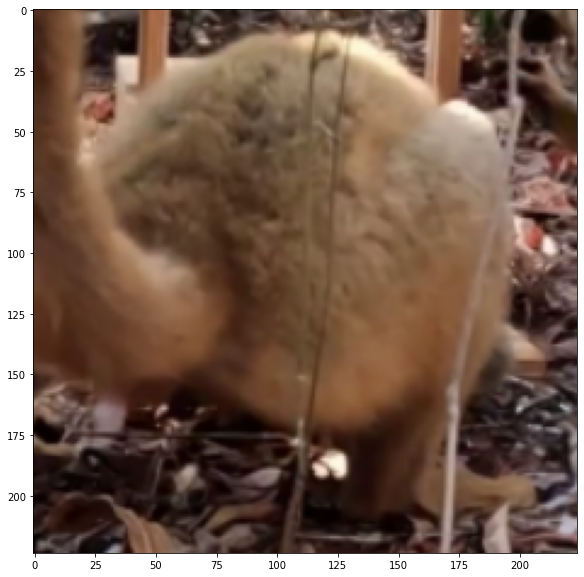

In [27]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
image, coords = plot_bbox_w_id(img0, bboxes[selected:(selected+1),0:4].numpy() * 4, crop = True)

ax.imshow(image)


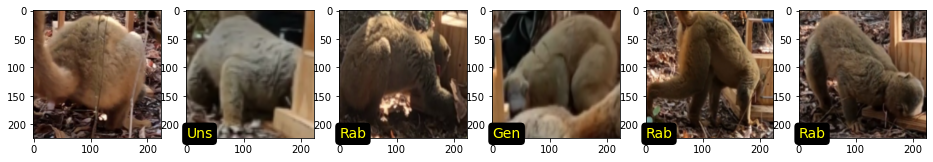

In [28]:
n = len(nearest_neighbors_indices)
fig, ax = plt.subplots(1, n + 1, figsize=(16, 10))

image, coords = plot_bbox_w_id(img0, bboxes[selected:(selected+1),0:4].numpy() * 4, crop = True)

ax[0].imshow(image)

for i, index in enumerate(nearest_neighbors_indices):

    label = train_labels[index]
    frame = train_frames[index]

    image, img_path, original_shape, labels = dset.__getitem__(frame)

    labels = labels[(labels[:,0]==0) & (labels[:,6]==label),:]

    img1 = np.moveaxis(image, 0, -1)
    gt_bbox = torch.Tensor(labels[:, 2:6])

    image, coords = plot_bbox_w_id(img1, gt_bbox.numpy(), crop = True)

    ax[i+1].imshow(image)

    for j, c in enumerate(coords):
        ax[i+1].annotate(class_names[int(labels[j,-1])], xy=(0, 0), 
                   xycoords='axes fraction', fontsize=14, color = "yellow",
                    bbox=dict(boxstyle='round', facecolor='black', edgecolor='none'))
        